In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import json 
import re 
import pickle
from tensorflow.keras.models import Model, load_model, save_model
# from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
# from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ,CSVLogger
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K
from math import ceil
%matplotlib inline

# load data part 1
we want load the image and the mask we creat them with mask maker script and save in  below dirs : 
- annotation_data_1/MASKS
- annotation_data_1/IMAGES

In [2]:
def load_data_1(image_size=(256,256),to_array=True):
    all_image=[]
    all_mask=[]
#     dataset_path='/kaggle/input/brain-tumor-segmentation'
    image_path='annotation_data_1/IMAGES'
    mask_path='annotation_data_1/MASKS'
    images_name=os.listdir(image_path)
    


    for image_name in images_name :

        image=cv.imread(image_path+'/'+image_name,0)
        image=cv.resize(image,image_size)
        image=image/255.0
        image= image.astype(np.float32)
        all_image.append(image)
        image_1=cv.imread(mask_path+'/'+image_name,0)

        image_1=cv.resize(image_1,image_size)

        image_1=image_1/255.0
        image_1= image_1.astype(np.float32)
        all_mask.append(image_1)

    if to_array==True : 
        all_image=np.array(all_image)
        all_mask=np.array(all_mask)
    return all_image,all_mask

x_1,y_1=load_data_1(to_array=False)


In [ ]:
print(type(x_1),type(y_1))
print(len(x_1),len(y_1))

# load data part 2 
first we have to split the specific type of mri and then load them 

In [3]:
def load_2d_mri(dataset='image_dataset',images='image_dataset/images',masks='image_dataset/masks'):
    
    
    

    start_list=['1.png','709.png','922.png','1283.png','1841.png','2344.png']
    stop_list=['210.png','746.png','1033.png','1455.png','2241.png','2402.png']
    length_manage_list=len(stop_list)-1
    
    all_image_name=os.listdir(images)
    flag=False
    g=0
    lst=[]
    for name in range(1,len(all_image_name)+1) : 
        
        name=f"{name}.png"
        if name==start_list[g]:
            flag=True
#             print(name)
        if flag==True : 
            lst.append(name)
            
        if name==stop_list[g]:
            flag=False
            if length_manage_list!= g : 
                g+=1
#             print(name)
#             print(g)
    return lst
# all_img_name=load_2d_mri()
# print(len(all_img_name))
#--------------------------------------------------
def load_data_2(image_size=(256,256),to_array=True,image_path='image_dataset/images',mask_path='image_dataset/masks'):
    all_image=[]
    all_mask=[]

    images_name=load_2d_mri()


    for image_name in images_name :

        image=cv.imread(image_path+'/'+image_name,0)
        image=cv.resize(image,image_size)
        image=image/255.0
        image= image.astype(np.float32)
        all_image.append(image)
        image_1=cv.imread(mask_path+'/'+image_name,0)

        image_1=cv.resize(image_1,image_size)

        image_1=image_1/255.0
        image_1= image_1.astype(np.float32)
        all_mask.append(image_1)

    if to_array==True : 
        all_image=np.array(all_image)
        all_mask=np.array(all_mask)
    return all_image,all_mask
x_2,y_2=load_data_2(to_array=False)

In [ ]:
print(type(x_2),type(y_2))
print(len(x_2),len(y_2))

# merge 2 part of data

In [4]:
def merge_data():
    x_final=[]
    y_final=[]
    x_final.extend(x_1)
    x_final.extend(x_2)
    y_final.extend(y_1)
    y_final.extend(y_2)
    x_final=np.array(x_final)
    y_final=np.array(y_final)
    print(x_final.shape,y_final.shape)
    return x_final,y_final
x_final,y_final=merge_data()


(1790, 256, 256) (1790, 256, 256)


# splitting data
for training data we have to split our data 
- train dataset 0.8
- validate dataset 0.1 (optional)
- test dataset 0.1

In [5]:
def split_data(test_size=0.2,log=True,shuffle=True):  
    x_train, x_test_val, y_train, y_test_val = train_test_split(x_final, y_final, test_size=test_size,shuffle=shuffle)
    if log==True : 
        print('Input: ')
        print(x_final.shape,(y_final).shape)
        print('----------------------------')
        
    x_test=x_test_val[:int(len(x_test_val)*0.5)]
    x_val=x_test_val[int(len(x_test_val)*0.5):]
    y_test=y_test_val[:int(len(y_test_val)*0.5)]
    y_val=y_test_val[int(len(y_test_val)*0.5):]


    x_train=x_train.reshape(-1,256,256,1)
    y_train=y_train.reshape(-1,256,256,1)
    x_test=x_test.reshape(-1,256,256,1)
    y_test=y_test.reshape(-1,256,256,1)
    x_val=x_val.reshape(-1,256,256,1)
    y_val=y_val.reshape(-1,256,256,1)
    if log==True : 
        print('Output: ')
        print(x_train.shape,y_train.shape)
        print(x_test.shape,(y_test).shape)
        print(x_val.shape,y_val.shape)
        print('----------------------------')
    return x_train,y_train,x_test,y_test,x_val,y_val
x_train,y_train,x_test,y_test,x_val,y_val=split_data()
validation_dataset=(x_val,y_val)

Input: 
(1790, 256, 256) (1790, 256, 256)
----------------------------
Output: 
(1432, 256, 256, 1) (1432, 256, 256, 1)
(179, 256, 256, 1) (179, 256, 256, 1)
(179, 256, 256, 1) (179, 256, 256, 1)
----------------------------


# Build U-Net Model
we have to apply sementic segmentation Model
usually we apply Unet Model for medical purpose
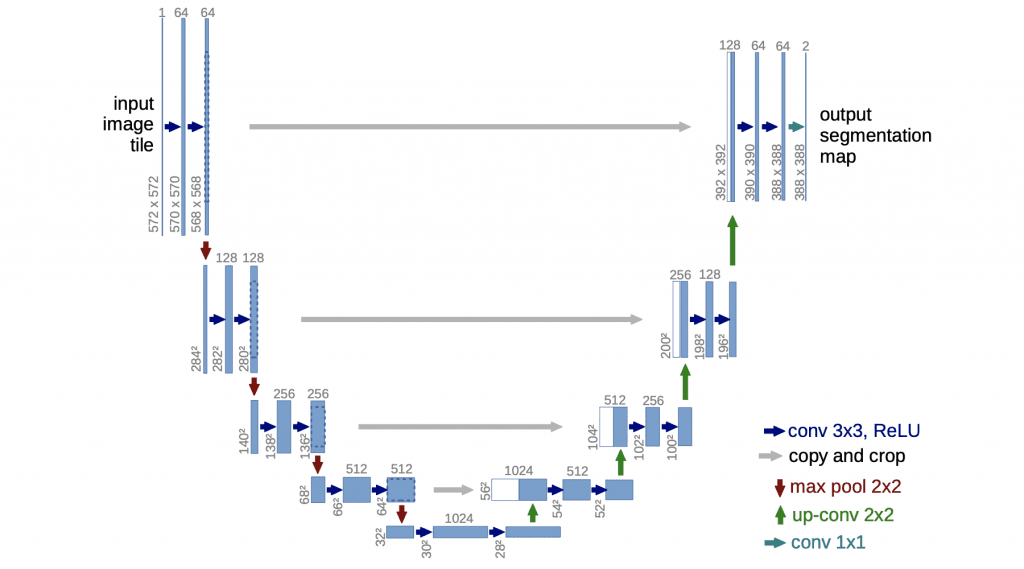

In [ ]:
def double_conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def Build_Unet_Model(num_filters=64,input_shape=(256,256,1)):
    inputs = Input(input_shape)
    f_1 = double_conv_block(inputs, num_filters*1)
    p_1 = MaxPool2D((2, 2))(f_1)
    f_2 = double_conv_block(p_1, num_filters*2)
    p_2 = MaxPool2D((2, 2))(f_2)
    f_3 = double_conv_block(p_2, num_filters*4)
    p_3 = MaxPool2D((2, 2))(f_3)
    f_4 = double_conv_block(p_3, num_filters*8)
    p_4 = MaxPool2D((2, 2))(f_4)
    
    c=double_conv_block(p_4,num_filters*16)
    
    d_1 = Conv2DTranspose(num_filters*8, 2, strides=2, padding="same")(c)
    d_1= Concatenate()([d_1, f_4])
    d_1 = double_conv_block(d_1, num_filters*8) 
    
    d_2 = Conv2DTranspose(num_filters*4, 2, strides=2, padding="same")(d_1)
    d_2= Concatenate()([d_2, f_3])
    d_2 = double_conv_block(d_2, num_filters*4)  
    
    d_3 = Conv2DTranspose(num_filters*2, 2, strides=2, padding="same")(d_2)
    d_3= Concatenate()([d_3, f_2])
    d_3 = double_conv_block(d_3, num_filters*2)   
    
    d_4 = Conv2DTranspose(num_filters*1, 2, strides=2, padding="same")(d_3)
    d_4= Concatenate()([d_4, f_1])
    d_4 = double_conv_block(d_4, num_filters*1)    
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d_4)
    Unet_Model = Model(inputs, outputs, name="UNetModel")
    return Unet_Model

In [ ]:
Unet_Model = Build_Unet_Model()
Unet_Model.summary()

# make own metrics and loss function 
we have to make special metrics and function loss for have better result <br />
in this case i use Dice_Coefficient metrics and Dice_Loss for loss function <br />
for better measuring loss and have better optimizing and at the end have better model 

In [6]:
def Dice_Coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2.0 * intersection + smooth)/(union + smooth), axis=0)
    return dice

def Dice_Loss(y_true, y_pred):
    return 1.0 - Dice_Coefficient(y_true, y_pred)

In [ ]:
Unet_Model.compile(loss=Dice_Loss , optimizer='adam', metrics=[Dice_Coefficient,"binary_accuracy"])

In [ ]:
def make_callbacks(csv_path='/kaggle/working/my_new_log_3.csv'):
    early_stop=EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=False)
    csv_logger=CSVLogger(csv_path)
    callbacks =[early_stop,csv_logger]
    return callbacks
callbacks=make_callbacks()

# time to train the Model

In [ ]:
epochs = 90
Unet_Model.fit(x_train, y_train, epochs=epochs,batch_size=16,verbose=1,validation_data=validation_dataset,callbacks=callbacks)

# saving the model

In [ ]:
Unet_Model.save('segmetation_parham.h5')

# loading model

In [7]:
Unet_Model = load_model('segmetation_parham.h5', custom_objects={'Dice_Loss':                   
Dice_Loss,'Dice_Coefficient':Dice_Coefficient})

In [8]:
print(type(Unet_Model))

<class 'keras.engine.functional.Functional'>


# Evaluate the model

In [9]:
Model_loss, Model_accuracy,*anything = Unet_Model.evaluate(x_test,y_test)

print(f"it is Model accuracy: {Model_accuracy}")
print(f'it is Model loss: {Model_loss}')

6/6 [==============================] - 57s 9s/step - loss: 0.3015 - Dice_Coefficient: 0.7014 - binary_accuracy: 0.9808
it is Model accuracy: 0.7013692259788513
it is Model loss: 0.3015402555465698


# Visualizing the output

1/1 [==============================] - 0s 339ms/step


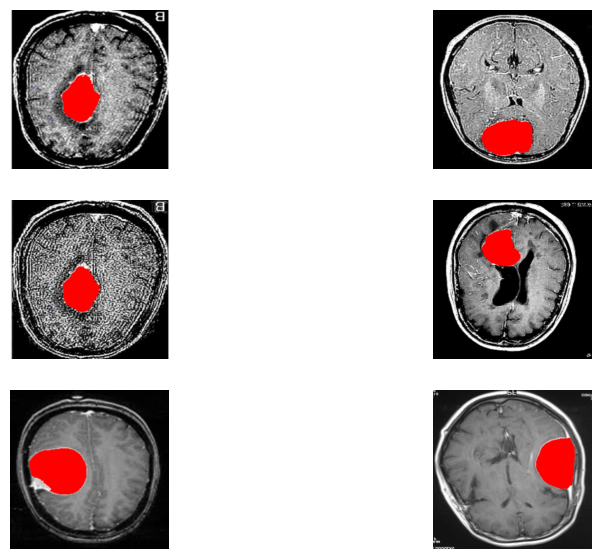

In [50]:
def threshold(array):
    array=array.flatten()
    flat_array=list(map(lambda x :255 if x>0.5 else 0,array))
    flat_array=np.array(flat_array)
    th=flat_array.reshape(256,256)
    return th 
def combine_pred_original(path,dir_path=False,plot=False):
    if dir_path==False : 
        image=cv.imread(path)
        image=cv.resize(image,(256,256))

        image_gray=cv.cvtColor(image,cv.COLOR_BGR2GRAY)

        image_1=image_gray / 255.0
        image_1= image_1.astype(np.float32)
        # plt.imshow(image,cmap='gray')

        image_1=image_1.reshape(-1,256,256,1)
        y_hat = Unet_Model.predict(image_1)

        y_hat=y_hat.reshape(256,256)
        mask=threshold(y_hat)
        finall_img=np.copy(image)
        index_mask=np.where(mask==255)
        finall_img[index_mask]=[0,0,255]
        finall_img=cv.resize(finall_img,(512,512))
        if plot==True : 
            plt.imshow(finall_img[:,:,::-1])
        return finall_img
    #     plt.imshow(image_gray,cmap='gray')
        
    else  :
        all_result={}
        all_img_name=os.listdir(path)
        image_count=len(all_img_name)
        if plot==True :
            rows,columns=3,ceil(image_count/3)
            fig = plt.figure(figsize=(10, 7))
        for c,name in enumerate(all_img_name) : 
            image=cv.imread(path+'/'+name)
            image=cv.resize(image,(256,256))

            image_gray=cv.cvtColor(image,cv.COLOR_BGR2GRAY)

            image_1=image_gray / 255.0
            image_1= image_1.astype(np.float32)
        # plt.imshow(image,cmap='gray')

            image_1=image_1.reshape(-1,256,256,1)
            y_hat = Unet_Model.predict(image_1)

            y_hat=y_hat.reshape(256,256)
            mask=threshold(y_hat)
            finall_img=np.copy(image)
            index_mask=np.where(mask==255)
            finall_img[index_mask]=[0,0,255]
            finall_img=cv.resize(finall_img,(512,512))
            all_result.update({name:finall_img})
            if plot==True :
                fig.add_subplot(rows, columns, c+1)
                plt.imshow(finall_img[:,:,::-1])
    
                plt.axis('off')
            
        return all_result
    
    

a=combine_pred_original(path='segmentation_testing',dir_path=True,plot=True)

In [5]:
csv=pd.read_csv('my_segmentation_log_6.csv')

accuracy=csv['Dice_Coefficient']
val_accuracy=csv['val_Dice_Coefficient']
loss=csv['loss']
val_loss=csv['val_loss']

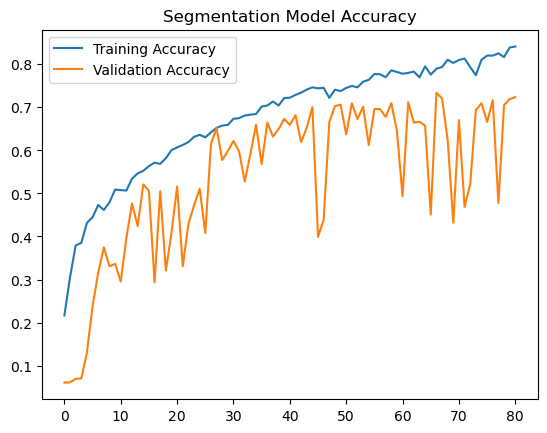

In [6]:
plt.plot(accuracy,label='Training Accuracy')
plt.plot(val_accuracy,label='Validation Accuracy')
plt.legend()
plt.title('Segmentation Model Accuracy')
plt.show()


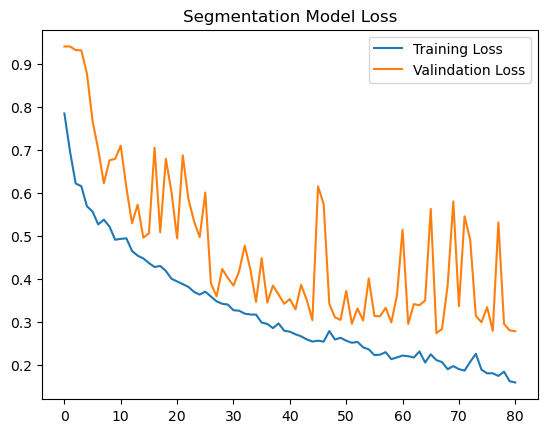

In [7]:
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Valindation Loss')
plt.legend()
plt.title('Segmentation Model Loss')
plt.show()